## Phylostan: BDSKY Check

#### Simulation

Using the R package $\texttt{Rcolgem},$ we simulate a compartment model with 4 compartments: susceptible $(S)$, infected $(I)$, recovered-hidden $(R_h)$, and recovered-sampled $(R_s).$ The demography can be expressed by the set of following equations:
\begin{align*}
    \frac{d}{dt}n_S(t) &= -\beta \frac{S(t)I(t)}{N(t)} \\
    \frac{d}{dt}n_I(t) &= \beta \frac{S(t)I(t)}{N(t)} - \gamma I(t) \\
    \frac{d}{dt}R_h(t) &= \gamma (1-s) I(t) \\
    \frac{d}{dt}R_s(t) &= \gamma s I(t),
\end{align*}
where $X(t)$ is the number of individuals in compartment $X$ at time $t$, $N$ is the total size of the population, $\beta$ is the rate an infected individual infects a susceptible, $\gamma$ is the rate of an infectious individual recovering, and $s$ is the probability of a recovery being observed.

We initialize the demographic process with the following settings:
\begin{align*}
    S(0) &= 999 \\
    I(0) &= 1 \\
    \beta &= 0.75 \\
    \gamma &= 0.3 \\
    s &= 0.1.
\end{align*}

Using the tree generated from the model we can simulate sequences using the $\texttt{genSeq}$ in the $\texttt{phytools}$ package.

#### Check

We analyze the tree and sequence data using Phylostan under the following model

1. Mutation model: GTR
2. Tree prior: Bdsky
3. Frequencies and relative rate: Dirichlet Priors
4. Variational Distribution: Mean field

Sample size 10000

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Bio import Phylo

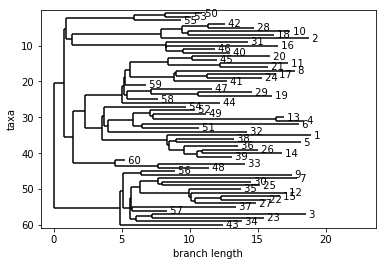

In [2]:
tree = Phylo.read('sim.tree', 'newick')
Phylo.draw(tree)

In [3]:
seeds = [2,3,4,5,6,7,8,9,11,12]
stem = 'output/'
num_seeds = len(seeds)
m = 10
n = 10000

R = np.empty((num_seeds,m,n+1))
delta = np.empty((num_seeds,m,n+1))
s = np.empty((num_seeds,m,n+1))

for i in range(num_seeds):
    seed = seeds[i]
    with open(f'{stem}sim_{seed}') as fp:
        data = []
        for line in fp:
            line = line.strip()
            if line.startswith('lp'):
                header = line.split(',')
                [data.append([]) for _ in range(len(header))]
            elif not line.startswith('#') and len(line) != 0:
                for idx, h in enumerate(line.split(',')):
                    data[idx].append(float(h))

        def parse_helper(var):
            d = []
            for h in header:
                if h.startswith(f'{var}'):
                    d.append(data[header.index(h)])
            return d
        R[i] = np.array(parse_helper('R'))
        delta[i] = np.array(parse_helper('delta'))
        s[i] = np.array(parse_helper('s'))

In [4]:
import json
with open("R.json") as f:
    truth = json.load(f)

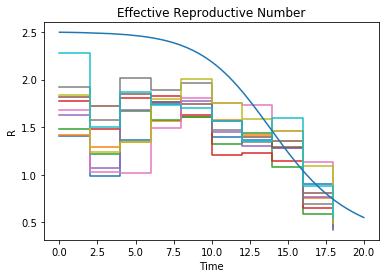

In [5]:
x = np.linspace(0,18,m)
y = np.median(R, axis=2)
for i in range(num_seeds):
    _ = plt.plot(x, y[i], drawstyle='steps-post')
truth_x = np.linspace(0,20,1000)
_ = plt.plot(truth_x, truth)
_ = plt.xlabel('Time')
_ = plt.ylabel('R')
_ = plt.title('Effective Reproductive Number')

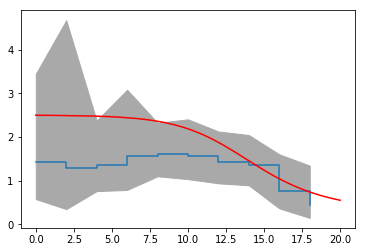

In [6]:
i = 1
l, u = np.quantile(R, (0.025, 0.975), 2)
_ = plt.fill_between(np.linspace(0,18,m), l[i], u[i], color='darkgray')
_ = plt.plot(x, y[i], drawstyle='steps-post')
_ = plt.plot(truth_x, truth, color='r')

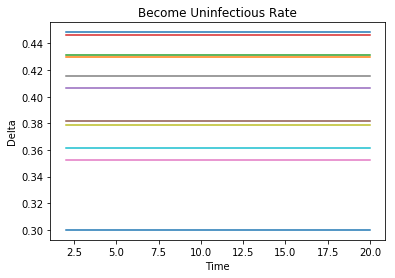

In [7]:
x = np.linspace(2,20,m)
for i in range(num_seeds):
    y = np.median(delta, axis=2)
    _ = plt.plot(x, y[i], drawstyle='steps-pre')
_ = plt.plot(x, [0.3] * m, drawstyle='steps-pre')
_ = plt.xlabel('Time')
_ = plt.ylabel('Delta')
_ = plt.title('Become Uninfectious Rate')

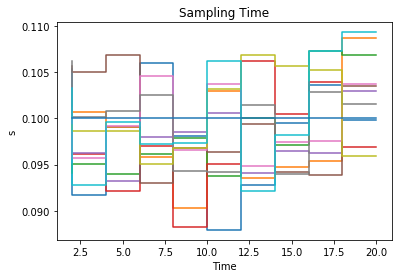

In [8]:
x = np.linspace(2,20,m)
for i in range(num_seeds):
    y = np.median(s, axis=2)
    _ = plt.plot(x, y[i], drawstyle='steps-pre')
_ = plt.plot(x, [0.1] * m, drawstyle='steps-pre')
_ = plt.xlabel('Time')
_ = plt.ylabel('s')
_ = plt.title('Sampling Time')